In [1]:
# import
import pandas as pd
import numpy as np
import re
import sqlite3
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Joining

### Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [2]:
# Load data from sources
stations = pd.read_csv('../data/stations.csv', index_col=None)
fsq_pois = pd.read_csv('../data/fsq_businesses.csv', index_col=None)

stations.head()

,station_name,latitude,longitude,total_bikes,station
0,de la Commune / Place Jacques-Cartier,45.507610,-73.551836,78,0
1,de la Commune / King,45.497504,-73.552845,62,1
2,Jeanne-Mance / René-Lévesque,45.506371,-73.564201,55,2
3,Métro Viau (Viau / Pierre-de-Coubertin),45.563084,-73.548194,50,3
4,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070,48,4


### Create the 'station' column using a dictionary

In [3]:
# locations dictionary
locations = stations.set_index(['latitude', 'longitude'])['station'].to_dict()

# station column
fsq_pois['station'] = fsq_pois.apply(lambda row: locations.get((row['latitude'], row['longitude']), 9999), axis=1)
fsq_pois.head()

,fsq_id,name,latitude,longitude,category_id,category_name,distance,rating,popularity,price,station
0,4cb240b8cbab236ae154af73,Restaurant Prima Luna,45.6175,-73.606011,13236,Italian Restaurant,941,7.4,0.985,1.0,790
1,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,13034,Café,79,NaN,0.869,1.0,790
2,4ea9b28cb803cf1ffacd7c0d,Café l'Exil,45.6175,-73.606011,13035,Coffee Shop,79,NaN,0.869,1.0,790
3,4de7c3322271b9ccf4e4edbe,Capucine,45.6175,-73.606011,13002,Bakery,240,NaN,0.991,2.0,790
4,4de7c3322271b9ccf4e4edbe,Capucine,45.6175,-73.606011,13236,Italian Restaurant,240,NaN,0.991,2.0,790


In [4]:
# Grouping the POI per stations with their chacteristics
grouped_poi = fsq_pois[['station','distance', 'rating', 'popularity', 'price']].groupby('station').mean().sort_values('station')
grouped_poi.head()

,distance,rating,popularity,price
station,,,,
0,529.829268,8.540244,0.959988,1.846154
1,614.240964,8.438554,0.954566,2.013699
2,644.576923,8.547436,0.972256,1.760563
3,703.777778,7.483333,0.942667,1.333333
4,401.109756,8.051220,0.974317,1.777778


In [5]:
# Merge with Part 1
bike_rentals = pd.merge(stations, grouped_poi, on='station')
bike_rentals.head()

,station_name,latitude,longitude,total_bikes,station,distance,rating,popularity,price
0,de la Commune / Place Jacques-Cartier,45.507610,-73.551836,78,0,529.829268,8.540244,0.959988,1.846154
1,de la Commune / King,45.497504,-73.552845,62,1,614.240964,8.438554,0.954566,2.013699
2,Jeanne-Mance / René-Lévesque,45.506371,-73.564201,55,2,644.576923,8.547436,0.972256,1.760563
3,Métro Viau (Viau / Pierre-de-Coubertin),45.563084,-73.548194,50,3,703.777778,7.483333,0.942667,1.333333
4,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070,48,4,401.109756,8.051220,0.974317,1.777778


### Cleaning data


In [6]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 0 to 790
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_name  791 non-null    object 
 1   latitude      791 non-null    float64
 2   longitude     791 non-null    float64
 3   total_bikes   791 non-null    int64  
 4   station       791 non-null    int64  
 5   distance      791 non-null    float64
 6   rating        779 non-null    float64
 7   popularity    791 non-null    float64
 8   price         789 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 61.8+ KB


- Looks like we have some stations with no data

In [7]:
bike_rentals[(bike_rentals['price'].isnull()) | (bike_rentals['rating'].isnull())]

,station_name,latitude,longitude,total_bikes,station,distance,rating,popularity,price
20,Hôpital Maisonneuve-Rosemont (Rosemont / Chate...,45.575707,-73.561562,38,20,870.00,NaN,0.879333,1.666667
46,Papineau / Émile-Journault,45.559884,-73.633568,32,46,742.00,NaN,0.942333,1.333333
158,Métro Édouard-Montpetit (du Mont-Royal / Vince...,45.510200,-73.611405,25,158,221.00,NaN,0.884000,2.000000
237,Rosemont / Viau,45.568330,-73.566663,23,237,730.00,NaN,0.877800,1.200000
381,Gare LaSalle (Highlands),45.425613,-73.657136,19,381,566.00,NaN,0.927000,2.000000
407,Parc de l'Hôtel-de-Ville (Ste-Julie / Laurendeau),45.630686,-73.494847,19,408,379.50,NaN,0.916000,1.000000
440,41e avenue / Rosemont,45.571790,-73.564315,19,441,583.00,NaN,0.871500,1.500000
521,Parc Ernest-Rouleau (Gouin),45.631313,-73.616315,18,524,983.00,NaN,0.892000,NaN
617,Centre récréatif Édouard-Rivet (Notre-Dame / L...,45.628462,-73.499522,15,620,763.50,NaN,0.916000,1.000000
717,LaSalle / 90e avenue,45.417746,-73.645188,14,721,768.75,NaN,0.905250,2.333333


In [8]:
# Filtering them out
filtered_rentals = bike_rentals.dropna(subset=['rating', 'price'])
filtered_rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779 entries, 0 to 790
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_name  779 non-null    object 
 1   latitude      779 non-null    float64
 2   longitude     779 non-null    float64
 3   total_bikes   779 non-null    int64  
 4   station       779 non-null    int64  
 5   distance      779 non-null    float64
 6   rating        779 non-null    float64
 7   popularity    779 non-null    float64
 8   price         779 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 60.9+ KB


In [9]:
filtered_rentals.describe()

,latitude,longitude,total_bikes,station,distance,rating,popularity,price
count,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000
mean,45.523493,-73.593161,20.921694,395.982028,633.989173,7.583399,0.941357,1.525064
std,0.038863,0.047851,6.938976,229.587570,116.393808,0.691117,0.019425,0.227015
min,45.416295,-73.758227,5.000000,0.000000,39.000000,5.400000,0.869900,1.000000
25%,45.501834,-73.615897,16.000000,197.500000,571.547184,7.016667,0.932627,1.385490
50%,45.524790,-73.582596,19.000000,394.000000,641.383178,7.672500,0.939958,1.530612
75%,45.544843,-73.565415,23.000000,594.500000,710.535944,8.182363,0.952069,1.673691
max,45.702349,-73.436058,78.000000,796.000000,980.000000,8.718667,0.996000,3.000000


## Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

<Figure size 1200x800 with 0 Axes>

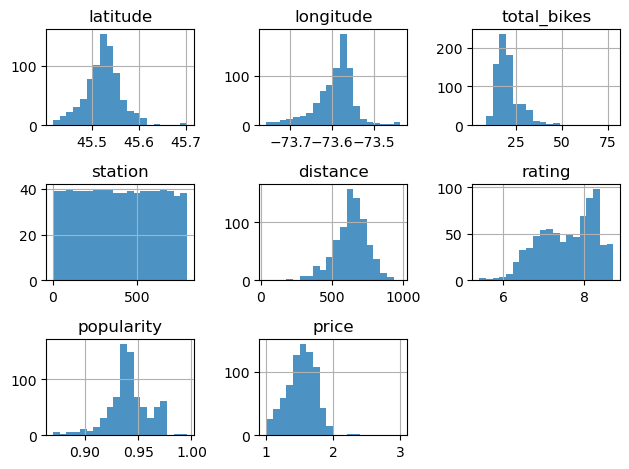

In [10]:
# Histogram of each variables (filtered data)
plt.figure(figsize=(12, 8))
filtered_rentals.hist(bins=20, alpha=0.8)
plt.tight_layout()

#### OVERVIEW
- Dependant variable:
    + Total_bikes seems to have some outliers with a lot of bikes compare to the other station
- Independant variables:
    + Rating is not normally distributed, and we could remove the stations below a rating of 6.
    + Popularity looks more like a normal distributon
    + Price still have some outliers above 2. Removing them would center the curve.

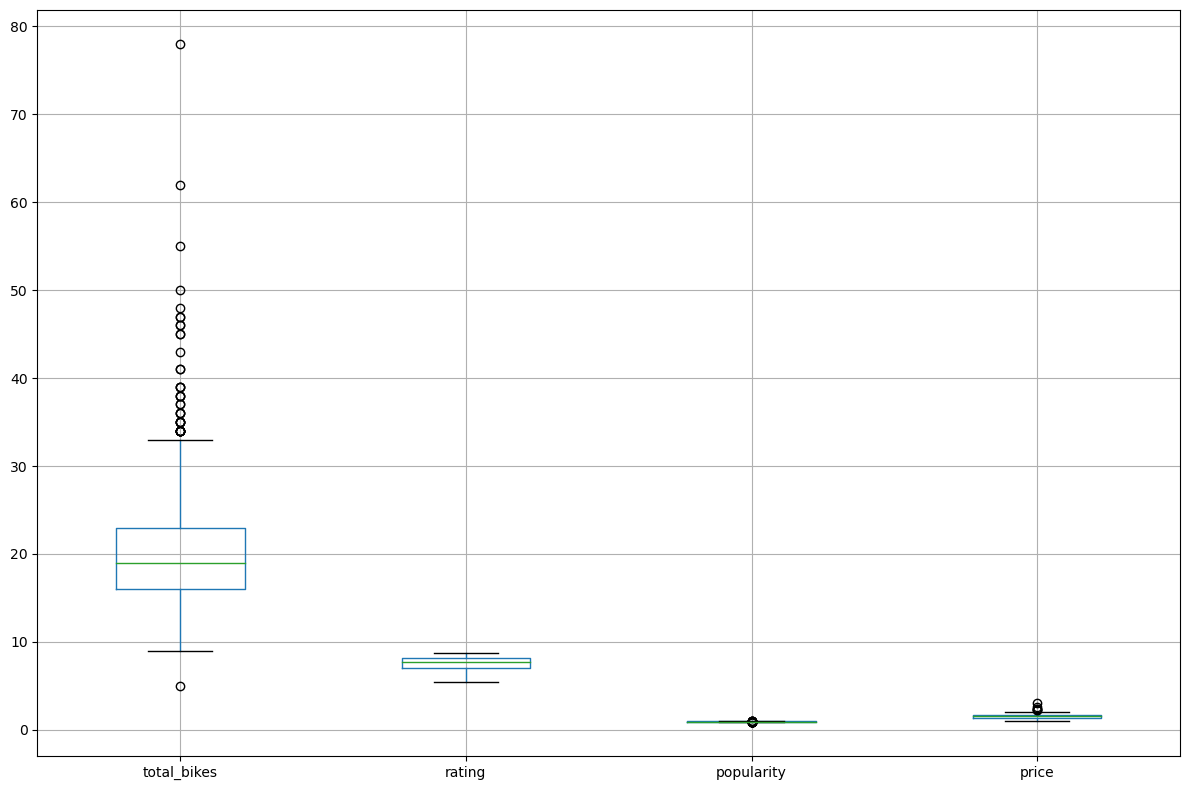

In [11]:
# Validate outliers
plt.figure(figsize=(12, 8))
filtered_rentals[['total_bikes', 'rating', 'popularity', 'price']].boxplot()
plt.tight_layout()

In [12]:
# Removing outliers
filtered_rentals = (
    filtered_rentals[
        (filtered_rentals['total_bikes'].between(10, 50)) &
        (filtered_rentals['rating'] > 6) &
        (filtered_rentals['price'] < 2)
    ]
)
filtered_rentals.describe()

,latitude,longitude,total_bikes,station,distance,rating,popularity,price
count,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000
mean,45.523774,-73.592717,20.832454,394.042216,634.484225,7.605910,0.941351,1.519627
std,0.038666,0.046570,6.296266,226.774694,113.086660,0.663622,0.019438,0.207443
min,45.416295,-73.758227,10.000000,3.000000,186.560976,6.080000,0.869900,1.000000
25%,45.501989,-73.615072,16.000000,198.250000,572.187425,7.057563,0.932697,1.388889
50%,45.525353,-73.582643,19.000000,390.500000,641.670129,7.696154,0.939917,1.530012
75%,45.544760,-73.565926,23.000000,588.750000,710.003269,8.186462,0.952028,1.669608
max,45.702349,-73.436058,50.000000,793.000000,980.000000,8.718667,0.996000,1.973333


#### OVERVIEW:
Looks like all the means now are close to the median.

In [13]:
# Save a copy of the merged data
filtered_rentals.to_csv('../data/bike_rentals.csv', index=None)

### Relationship

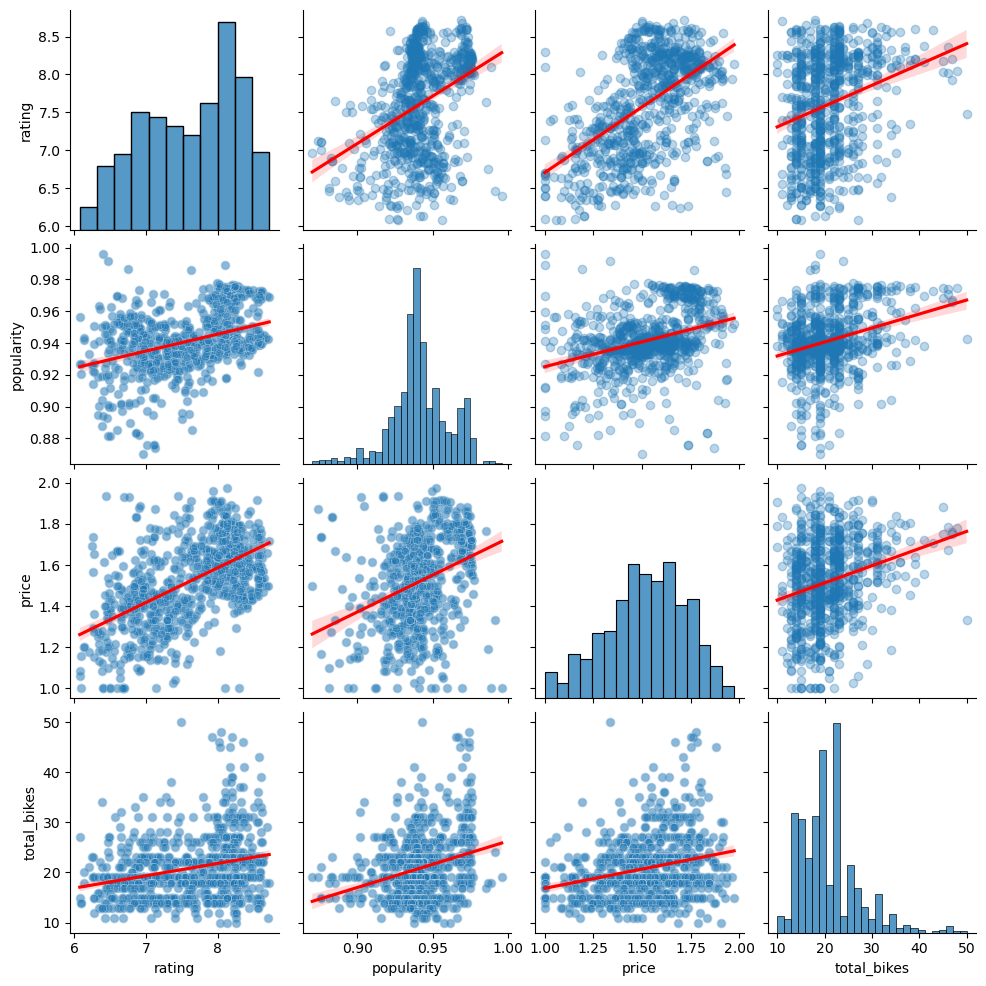

In [14]:
# Visualize relationship with the dependant variable
ind_var = ['rating', 'popularity', 'price']
dep_var = ['total_bikes']

# Create a DataFrame with the variables
vars_to_plot = ind_var + dep_var
data_to_plot = filtered_rentals[vars_to_plot]

# Create a pair plot
g = sns.pairplot(data_to_plot, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}})
g.map_lower(sns.scatterplot, alpha=0.3)


#### OVERVIEW
- The only 'visible' relationship between independant variables is the one between rating and price, thought not strong. We could choose either of them for the modelling.
- As for the relationship between 'total_bikes" and all the independant variables, they are all similar, showing a weak positve relationship.


### CORRELATION

Text(0.5, 1.0, 'Correlation Heatmap')

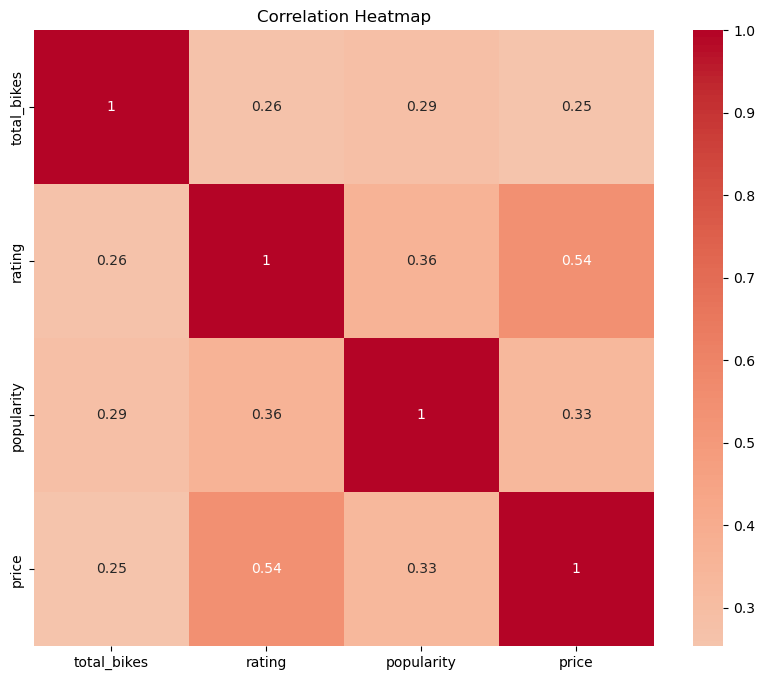

In [ ]:
# Correlation
correlation_matrix = filtered_rentals[['total_bikes', 'rating', 'popularity', 'price']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')

#### OVERVIEW
- As expected, rating and price have the strongest correlation. We will use rating for the model since the price is almost the same scale (1 to 2: inexpensive) for every POI.
- All independant variable have the same weak (25%) correlation with the dependant variable. Not really good for our model.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

### Creating functions and connection info

In [ ]:
# Connection function
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [ ]:
# Query function
def execute_query(queries, cursor):
    try:
        for query in queries:
            cursor.execute(query)
        
        # Commit only if all statements succeeded
        cursor.connection.commit()
        print("Queries executed successfully")

    except sqlite3.Error as e:
        print("An error occurred:", e)
        # Rollback the transaction in case of error
        cursor.connection.rollback()

### Phase 1a: Create tables<br>
- **stations**: to hold information related to the stations location in the city along with their total bikes
- **pois**: to hold the information about each POI (including rating, popularity, price)
- **categories**: simulates the api category for Foursquare
- **poi_category**: joining table for poi and categories (many-to-many)
- **prices**: to holds the definition of the prices number
- **poi_detail**: creates the relation between data (station, poi_id, distance to the station)

In [ ]:
# CREATE TABLE queries in related order
create_table_queries = [
"""
CREATE TABLE IF NOT EXISTS stations (
  station_id INTEGER PRIMARY KEY AUTOINCREMENT,
  station_name VARCHAR NOT NULL,
  s_lat FLOAT NOT NULL,
  s_lon FLOAT NOT NULL,
  total_bikes INTEGER NOT NULL
);
""",
"""
CREATE TABLE IF NOT EXISTS categories (
  category_id INTEGER PRIMARY KEY,
  category_name VARCHAR NOT NULL,
);
""",
"""
CREATE TABLE IF NOT EXISTS prices (
  price INTEGER PRIMARY KEY,
  price_name VARCHAR NOT NULL
);
""",
"""
CREATE TABLE IF NOT EXISTS pois (
  poi_id INTEGER PRIMARY KEY AUTOINCREMENT,
  api_number VARCHAR NOT NULL,
  api_name VARCHAR NOT NULL,
  poi_name VARCHAR NOT NULL,
  p_lat FLOAT NOT NULL,
  p_lon FLOAT NOT NULL,
  rating INTEGER,
  popularity FLOAT,
  price INTEGER,
  FOREIGN KEY (price) REFERENCES prices(price)
);
""",
"""
CREATE TABLE IF NOT EXISTS poi_category (
  poi_id INTEGER NOT NULL,
  category_id INTEGER NOT NULL,
  PRIMARY KEY (poi_id, category_id),
  FOREIGN KEY (poi_id) REFERENCES pois(poi_id),
  FOREIGN KEY (category_id) REFERENCES categories(category_id)
""",
"""
CREATE TABLE IF NOT EXISTS poi_detail (
  data_id INTEGER PRIMARY KEY AUTOINCREMENT,
  station_id INTEGER NOT NULL,
  poi_id INTEGER NOT NULL,
  to_station_m INTEGER NOT NULL,
  FOREIGN KEY (station_id) REFERENCES stations(station_id),
  FOREIGN KEY (poi_id) REFERENCES pois(poi_id)
);
"""
]

In [ ]:
# Create connection and cursor
conn = create_connection('../data/mtl_bike_rentals.sqlite')

In [ ]:
# Create cursor
cursor = conn.cursor()

# Call the function to create the tables
execute_queries(create_table_queries, cursor)

In [ ]:
# Insert data query for stations table
insert_stations = [
"""
INSERT INTO
  users (name, age, gender, nationality)
VALUES
  ('James', 25, 'male', 'USA'),
  ('Leila', 32, 'female', 'France'),
  ('Brigitte', 35, 'female', 'England'),
  ('Mike', 40, 'male', 'Denmark'),
  ('Elizabeth', 21, 'female', 'Canada');
"""
]
# Call the function to execute queries
execute_queries(connection, insert_stations, cursor)

In [ ]:
# Close the cursor and connection
cursor.close()
connection.close()

### Phase 2: Read data

Look at the data before and after the join to validate your data.

In [ ]:
def execute_read_query(query, cursor):
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

In [ ]:
select_users = "SELECT * from users"
users = execute_read_query(connection, select_users)

for user in users:
    print(user)